# Word2vec from scratch in PyTorch

what is goal of word2vec (generate word embeddings)
why are word embeddings good
why is word2vec interesting

key idea of training word2vec (know ye a word by it's context)

there is nothing optimized about this

create a dataset that produces a bag of words and the target word
create a model
train the model
visualize stuff


In [1]:
# Imports and notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

# Create directory to store training data.
user_list = !whoami
username = user_list[0]
PATH = f'/home/{username}/data/word2vec/'
os.makedirs(PATH, exist_ok=True)

In [2]:
# This notebook assumes that you have Nvidia CUDA available. If it is not, change all `.cuda()` calls to `.cpu()`
import torch
assert torch.cuda.is_available(), 'CUDA is not available.'
assert torch.backends.cudnn.enabled, 'CuDNN is not available.'

### Creare a dataset
- get the text
- split up words
- turn words into a set of bags of words of size 7
- feed words into model
- visualize how words are distributed

In [80]:
# Thanks Matt! - http://mattmahoney.net/dc/textdata.html
SOURCE_URL = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'
TARGET_FILE = f'{PATH}squad.json'
if not os.path.exists(TARGET_FILE):
    !wget -O $TARGET_FILE $SOURCE_URL

In [83]:
import json

import spacy
from torch.utils.data import Dataset

tokenizer = spacy.load('en')

class TextDataset(Dataset):
    def __init__(self, bag_size):
        """
        bag_size: The number of words are in the 'bag of words'. Does not include predicted word.
        """
        assert bag_size > 1, 'Bag of words must be 2 or more words.'
        self.bag_size = bag_size
        
        with open(TARGET_FILE, 'r') as f:
            squad_data = json.load(f)

        texts = [] 
        for topic in squad_data['data']:
            for para in topic['paragraphs']:
                texts.append(para['context'])
                for qa in para['qas']:
                    texts.append(qa['question'])
                    for answer in qa['answers']:
                        texts.append(answer['text'])

        text = ' '.join(texts)[:1000000]

        self.text = [t.text for t in tokenizer(text)]
        self.word_set = sorted(list(set(self.text)))
        self.word_to_idx = {s: i for i, s in enumerate(self.word_set)}
        self.idx_to_word = {i: s for i, s in enumerate(self.word_set)}

    def __len__(self):
        """
        How many samples there are in the dataset.
        """
        return len(self.text) - self.bag_size
    
    def __getitem__(self, idx):
        """
        Get a training sample,
        """
        half_bag_size = self.bag_size // 2
        start = idx
        middle = idx + half_bag_size
        end = idx + self.bag_size + 1
        
        # Get the predicted word
        word = self.text[middle]
        
        # Get the bag of words by concatenating the preceding words with the following words
        preceding_words = self.text[start:middle]
        following_words = self.text[middle + 1:end] 
        word_bag = preceding_words + following_words

        # Convert words to integers
        inputs = torch.tensor([self.word_to_idx[word] for word in word_bag])
        label = self.word_to_idx[word]
        return inputs, label

# Check that dataset works

In [84]:
train_ds = TextDataset(bag_size=8)

In [85]:
# We can test out how the Dataset__getitem__ method works
print('Word to idx mapping from Dataset:')
for word in train_ds.text[:20]:
    print('\tidx', train_ds.word_to_idx[word], '\tword:', repr(word))

print('\nTraining samples from Dataset:')
for i in range(5):
    xs, y = train_ds[i]
    print('\n\tSample #no', i)
    print('\tlabel idx', y)
    print('\tlabel word', repr(train_ds.idx_to_word[y]))
    print('\tinput idxs', xs)
    print('\tinput words', repr([train_ds.idx_to_word[w.item()] for w in xs.data]))

Word to idx mapping from Dataset:
	idx 1448 	word: 'Beyoncé'
	idx 2662 	word: 'Giselle'
	idx 3295 	word: 'Knowles'
	idx 20 	word: '-'
	idx 1692 	word: 'Carter'
	idx 16 	word: '('
	idx 30 	word: '/biːˈjɒnseɪ/'
	idx 6648 	word: 'bee'
	idx 20 	word: '-'
	idx 5706 	word: 'YON'
	idx 20 	word: '-'
	idx 13390 	word: 'say'
	idx 17 	word: ')'
	idx 16 	word: '('
	idx 6825 	word: 'born'
	idx 4802 	word: 'September'
	idx 728 	word: '4'
	idx 19 	word: ','
	idx 499 	word: '1981'
	idx 17 	word: ')'

Training samples from Dataset:

	Sample #no 0
	label idx 1692
	label word 'Carter'
	input idxs tensor([1448, 2662, 3295,   20,   16,   30, 6648,   20])
	input words ['Beyoncé', 'Giselle', 'Knowles', '-', '(', '/biːˈjɒnseɪ/', 'bee', '-']

	Sample #no 1
	label idx 16
	label word '('
	input idxs tensor([2662, 3295,   20, 1692,   30, 6648,   20, 5706])
	input words ['Giselle', 'Knowles', '-', 'Carter', '/biːˈjɒnseɪ/', 'bee', '-', 'YON']

	Sample #no 2
	label idx 30
	label word '/biːˈjɒnseɪ/'
	input idxs tenso

# Create model

In [86]:
import torch.nn as nn

BAG_SIZE = 8
VOCAB_SIZE = len(train_ds.word_set)
EMBED_PARAMS = 100

class Word2VecNet(nn.Module):
    def __init__(self):
        super().__init__()        
        # Parameterized layers
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBED_PARAMS)
        self.dense = nn.Linear(EMBED_PARAMS, VOCAB_SIZE)
        self.softmax = nn.LogSoftmax(dim=1)
                             
    def forward(self, input_t):
        # Get a BAG_SIZE x EMBED_PARAMS set of embeddings for the context words
        batch_size, _ = input_t.shape
        context_embedding_acts = self.embedding(input_t)
        assert context_embedding_acts.shape == (batch_size, BAG_SIZE, EMBED_PARAMS)
        
        # Average the context word embeddings to get a vector of 1 x EMBED_PARAMS
        avg_context_embedding_acts = torch.mean(context_embedding_acts, dim=1)
        assert avg_context_embedding_acts.shape == (batch_size, EMBED_PARAMS)
        
        # Get a 1 x VOCAB_SIZE set of activations
        dense_acts = self.dense(avg_context_embedding_acts)
        assert dense_acts.shape == (batch_size, VOCAB_SIZE)
        
        # Make a prediction from output of dense layer
        prediction = self.softmax(dense_acts)
        assert prediction.shape == (batch_size, VOCAB_SIZE)
        return prediction

epoch 1 / 12, loss: 6.4851


epoch 2 / 12, loss: 4.6260


epoch 3 / 12, loss: 3.5338


epoch 4 / 12, loss: 2.7067


epoch 5 / 12, loss: 2.1088


epoch 6 / 12, loss: 1.6741


epoch 7 / 12, loss: 1.3857


epoch 8 / 12, loss: 1.1583


epoch 9 / 12, loss: 0.9995


epoch 10 / 12, loss: 0.8729


epoch 11 / 12, loss: 0.7739


epoch 12 / 12, loss: 0.6949


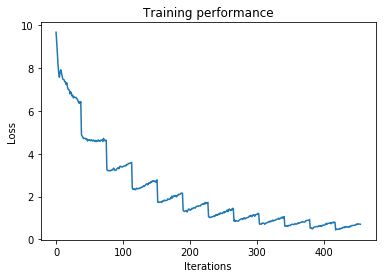

In [109]:
from utils import Trainer

net = Word2VecNet().cuda()
trainer = Trainer(
    net=net,
    data_set=train_ds,
    num_epochs=12,
    batch_size=5000,
    learning_rate=0.05,
)
trainer.train()

In [110]:
NET_PATH = f'{PATH}model.pt'
torch.save(net.state_dict(), NET_PATH)

In [111]:
net = Word2VecNet()
net.load_state_dict(torch.load(NET_PATH))

In [112]:
def PCA(data, k=2):
     data_mean = torch.mean(data, 0)
     X = data - data_mean.expand_as(data)
     U, S, V = torch.svd(torch.t(X))
     return torch.mm(X, U[:,:k])

In [ ]:
#http://ruder.io/word-embeddings-1/

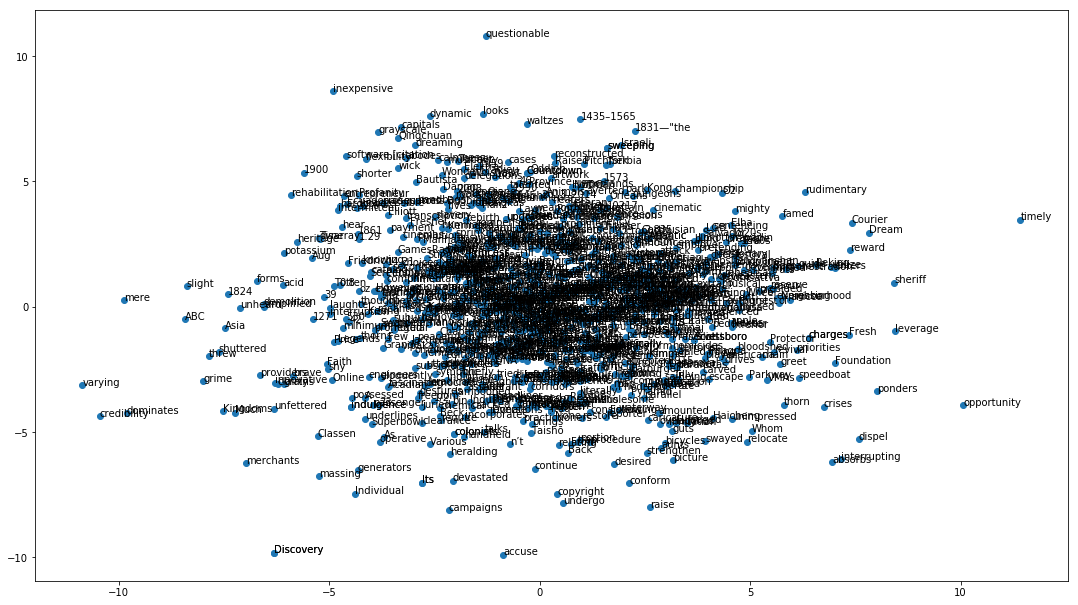

In [124]:
import random
test_words = random.choices(train_ds.word_set, k=1000)
test_word_batch = torch.tensor([
    train_ds.word_to_idx[word] 
    for word in test_words
])
test_word_batch_embeddings = net.embedding(test_word_batch)
test_word_batch_2D = PCA(test_word_batch_embeddings).detach().numpy()

# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2)
# test_word_batch_2D = tsne.fit_transform(test_word_batch_embeddings.detach().numpy())



fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.scatter(test_word_batch_2D[:, 0], test_word_batch_2D[:, 1])

for i, word in enumerate(test_words):
    ax.annotate(word, (test_word_batch_2D[i, 0], test_word_batch_2D[i, 1]))
